In [1]:
#load libraries
import os
import cv2
import random
import numpy as np
import imageio
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.backend import clear_session
clear_session()

2025-05-28 13:20:24.357316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748427624.376053    5133 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748427624.385240    5133 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-28 13:20:24.414767: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data path
data_path = "/home/meth/Documents/ETH/DCM/labelled_data" 
# Constants
image_size = (256, 256)

In [3]:
#function to threshold the mask
def threshold_mask(mask):
    """Convert a grayscale mask to a binary mask with values 0 and 1."""
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    binary_mask = binary_mask / 255  # Convert 255 to 1, so values become either 0 or 1
    return binary_mask

In [4]:
# Preprocessing utilities
def load_image(path):
    image = Image.open(path).convert('L')
    image_resized = image.resize(image_size, Image.BICUBIC)
    return np.array(image_resized) / 255.0

def load_mask(path):
    mask = Image.open(path).convert('L')
    mask_resized = mask.resize(image_size, Image.NEAREST)
    mask_binary = (np.array(mask_resized) > 128).astype(np.uint8)
    return mask_binary

In [5]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [6]:
def load_images_and_masks(data_path):
    """Load images and masks for segmentation from the given root path using imageio."""
    image_data = []
    mask_data = []
    patient_ids = []

    # Loop through all patient directories
    for patient_id in os.listdir(data_path):
        patient_path = os.path.join(data_path, patient_id)

        if os.path.isdir(patient_path):
            patient_ids.append(patient_id)  # Store patient ID

            # Process both 'ed' and 'es' folders
            for phase in ['ED']:
                phase_path = os.path.join(patient_path, phase)
                image_folder = os.path.join(phase_path, 'images')
                mask_folder = os.path.join(phase_path, 'masks')

                if os.path.exists(image_folder) and os.path.exists(mask_folder):
                    image_files = sorted(os.listdir(image_folder))
                    mask_files = sorted(os.listdir(mask_folder))

                    # Ensure that both image and mask files exist for each patient
                    if len(image_files) != len(mask_files):
                        print(f"Warning: Mismatch between image and mask files for patient {patient_id} in phase {phase}")
                    
                    for img_file, mask_file in zip(image_files, mask_files):
                        img_path = os.path.join(image_folder, img_file)
                        mask_path = os.path.join(mask_folder, mask_file)

                        # Read the image and mask files using imageio
                        try:
                            img = imageio.imread(img_path)
                            mask = imageio.imread(mask_path)

                            if img is not None and mask is not None:
                                # Resize and threshold the mask (to create binary mask)
                                img = cv2.resize(img, (256, 256))  # Resize image to standard size
                                mask = cv2.resize(mask, (256, 256))  # Resize mask to standard size
                                mask = threshold_mask(mask)  # Thresholding the mask to [0, 1]

                                # Append the image and mask to respective lists
                                image_data.append(img)
                                mask_data.append(mask)
                            else:
                                print(f"Warning: Failed to read image or mask for {patient_id}, phase {phase}")
                        except Exception as e:
                            print(f"Error reading {img_path} or {mask_path}: {e}")

    # Convert the lists into numpy arrays
    return np.array(image_data), np.array(mask_data), patient_ids

In [7]:
# Load data
images, masks, patient_ids = load_images_and_masks(data_path)
print("Loaded:", len(images), "samples.")

/tmp/ipykernel_5133/348510177.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
/tmp/ipykernel_5133/348510177.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


Loaded: 500 samples.


In [8]:
 #Split into train/val/test
random_seed = 42
unique_patient_ids = sorted(set(patient_ids))
train_val_ids, test_ids = train_test_split(unique_patient_ids, test_size=0.1, random_state=random_seed)
train_ids, val_ids = train_test_split(train_val_ids, test_size=50/450, random_state=random_seed)

In [9]:
def filter_by_ids(images, masks, patient_ids, selected_ids):
    X, Y = [], []
    for i, pid in enumerate(patient_ids):
        if pid in selected_ids:
            X.append(images[i])
            Y.append(masks[i])
    return np.array(X), np.array(Y)

In [10]:
train_images, train_masks = filter_by_ids(images, masks, patient_ids, train_ids)
val_images, val_masks = filter_by_ids(images, masks, patient_ids, val_ids)
test_images, test_masks = filter_by_ids(images, masks, patient_ids, test_ids)

In [11]:
print(val_images.shape, val_images.dtype)
print(val_masks.shape, val_masks.dtype)


(50, 256, 256) uint8
(50, 256, 256) float64


In [12]:
# Save test data
#np.savez("camus_test_data.npz", images=test_images, masks=test_masks)
# Save test data to folder
test_data_folder = "/home/meth/Documents/ETH/DCM/ed_2_test_data"
os.makedirs(test_data_folder, exist_ok=True)

for i, (img, mask) in enumerate(zip(test_images, test_masks)):
    patient_id = test_ids[i]  # Use the corresponding patient_id

    # Create a subdirectory for this patient
    patient_folder = os.path.join(test_data_folder, patient_id)
    os.makedirs(os.path.join(patient_folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(patient_folder, "masks"), exist_ok=True)

    # Define image and mask save paths
    img_path = os.path.join(patient_folder, "images", f"image_{i:03d}.png")
    mask_path = os.path.join(patient_folder, "masks", f"mask_{i:03d}.png")

    # Prepare data for saving
    img_uint8 = (img.squeeze() * 255).astype(np.uint8)
    mask_uint8 = (mask.squeeze() * 255).astype(np.uint8)

    # Save files
    imageio.imwrite(img_path, img_uint8)
    imageio.imwrite(mask_path, mask_uint8)

print(f"Saved {len(test_images)} test images and masks into patient folders under '{test_data_folder}/'")


Saved 50 test images and masks into patient folders under '/home/meth/Documents/ETH/DCM/ed_2_test_data/'


In [13]:
def unet_model(input_shape=(256, 256, 1), learning_rate=1e-4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model
# Create model
model = unet_model()
model.summary()

W0000 00:00:1748427632.773511    5133 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient, iou_metric]
)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train
checkpoint = ModelCheckpoint("unet_model.keras", save_best_only=True, monitor="val_loss")
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=60,
    batch_size=16,
    callbacks=checkpoint
)


Epoch 1/60


/home/meth/miniconda3/envs/milly/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 235s 9s/step - accuracy: 0.8286 - dice_coefficient: 0.1115 - iou_metric: 0.0615 - loss: 1.0861 - val_accuracy: 0.8870 - val_dice_coefficient: 0.3095 - val_iou_metric: 0.1832 - val_loss: 0.2566
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 227s 9s/step - accuracy: 0.8846 - dice_coefficient: 0.3259 - iou_metric: 0.1949 - loss: 0.2339 - val_accuracy: 0.8870 - val_dice_coefficient: 0.3649 - val_iou_metric: 0.2233 - val_loss: 0.1986
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 212s 8s/step - accuracy: 0.8976 - dice_coefficient: 0.4301 - iou_metric: 0.2757 - loss: 0.1819 - val_accuracy: 0.9501 - val_dice_coefficient: 0.5967 - val_iou_metric: 0.4253 - val_loss: 0.1302
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 282s 9s/step - accuracy: 0.9553 - dice_coefficient: 0.6662 - iou_metric: 0.5011 - loss: 0.1180 - val_accuracy: 0.9579 - val_dice_coefficient: 0.6731 - val_iou_metric: 0.5074 - val_loss: 0.1068
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 260s 9s/step - accuracy: 0.9514 - dice_coefficien

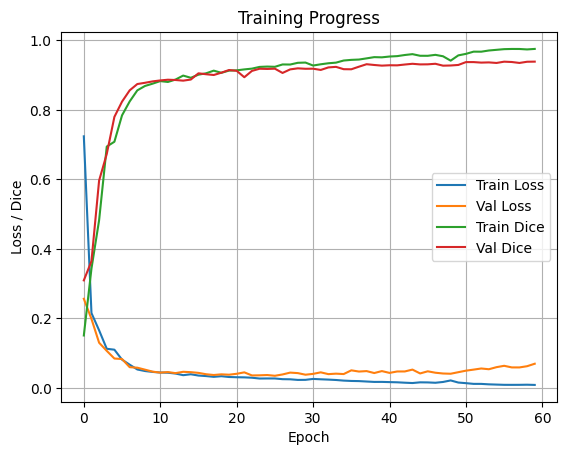

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation loss/metrics
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['dice_coefficient'], label='Train Dice')
plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
plt.legend()
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss / Dice')
plt.grid(True)
plt.show()

In [18]:
model.save("unet_ed_model_camus_ed_lr_ep60.keras")  